In [2885]:
# Import
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# from fastai.structured import add_datepart

# Linear Regression
from sklearn.linear_model import LogisticRegression

# Data Collecting

In [2886]:
# Config
symbl = 'MSFT'
apiKey = 'MSXSR0YHC991CZN6'

# Fetch Historical Data
# df = pd.read_csv('https://www.alphavantage.co/query?datatype=csv&function=TIME_SERIES_MONTHLY&symbol=' + symbl + '&outputsize=compact&apikey=' + apiKey)

# Use local data
df = pd.read_csv('data/monthly_MSFT.csv')

# Setting index as date
df['timestamp'] = pd.to_datetime(df.timestamp, format='%Y-%m-%d')
df.index = df['timestamp']

print

<function print>

# Data Overview

In [2887]:
# Get general statistics
df.describe()

,open,high,low,close,volume
count,256.000000,256.000000,256.000000,256.000000,2.560000e+02
mean,49.753136,53.349432,46.189302,49.653671,9.900380e+08
std,29.927316,33.005746,26.658620,29.682854,4.361976e+08
min,16.035000,18.880000,14.870000,16.150000,2.155232e+08
25%,27.235000,28.215000,25.855000,27.117425,6.457838e+08
50%,36.160000,37.695000,32.740000,36.205000,9.474929e+08
75%,64.358750,69.947500,60.617500,64.320000,1.301201e+09
max,175.440000,180.380000,143.980000,175.000000,3.044579e+09


In [2888]:
# Get data types
df.dtypes

timestamp    datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
volume                int64
dtype: object

In [2889]:
# Check top 10 rows
df.head(10)

,timestamp,open,high,low,close,volume
timestamp,,,,,,
2019-05-14,2019-05-14,130.530,130.650,123.0400,124.73,285095390
2019-04-30,2019-04-30,118.950,131.370,118.1000,130.60,433157868
2019-03-29,2019-03-29,112.890,120.820,108.8000,117.94,589045341
2019-02-28,2019-02-28,103.775,113.240,102.3500,112.03,469095970
2019-01-31,2019-01-31,99.550,107.900,97.2000,104.43,714204787
2018-12-31,2018-12-31,113.000,113.420,93.9600,101.57,944287635
2018-11-30,2018-11-30,107.050,112.240,99.3528,110.89,720228643
2018-10-31,2018-10-31,114.750,116.180,100.1100,106.81,927547942
2018-09-28,2018-09-28,110.850,115.290,107.2300,114.37,480255674


In [2890]:
# Check last 10 rows
df.tail(10)

,timestamp,open,high,low,close,volume
timestamp,,,,,,
1998-11-30,1998-11-30,106.37,130.27,104.75,122.00,290676700
1998-10-30,1998-10-30,108.06,110.12,87.75,105.87,410762300
1998-09-30,1998-09-30,95.25,114.62,94.50,110.06,298081100
1998-08-31,1998-08-31,109.12,113.75,95.75,95.94,337509900
1998-07-31,1998-07-31,109.12,119.62,105.37,109.94,307324500
1998-06-30,1998-06-30,83.87,108.56,83.12,108.37,308288100
1998-05-29,1998-05-29,90.19,91.00,81.87,84.81,273845600
1998-04-30,1998-04-30,89.81,99.12,86.62,90.12,254744300
1998-03-31,1998-03-31,85.87,90.94,79.25,89.50,274981900


## Convert closing price to trading action

In [2891]:
# Expected Return
expectedReturn = 0.000001

df['prev_close'] = df['close'].shift(-1)

df['action'] = np.nan 

for i, row in df.iterrows():
    realReturn = (df.loc[i, 'close'] / df.loc[i, 'prev_close']) - 1
    df.loc[i, 'action'] = 'L' if (realReturn >= expectedReturn) else 'S' # L = Long / S = Short


df.head(10)

,timestamp,open,high,low,close,volume,prev_close,action
timestamp,,,,,,,,
2019-05-14,2019-05-14,130.530,130.650,123.0400,124.73,285095390,130.60,S
2019-04-30,2019-04-30,118.950,131.370,118.1000,130.60,433157868,117.94,L
2019-03-29,2019-03-29,112.890,120.820,108.8000,117.94,589045341,112.03,L
2019-02-28,2019-02-28,103.775,113.240,102.3500,112.03,469095970,104.43,L
2019-01-31,2019-01-31,99.550,107.900,97.2000,104.43,714204787,101.57,L
2018-12-31,2018-12-31,113.000,113.420,93.9600,101.57,944287635,110.89,S
2018-11-30,2018-11-30,107.050,112.240,99.3528,110.89,720228643,106.81,L
2018-10-31,2018-10-31,114.750,116.180,100.1100,106.81,927547942,114.37,S
2018-09-28,2018-09-28,110.850,115.290,107.2300,114.37,480255674,112.33,L


## Prepare data to merge with sentimental analysis

In [2892]:
cropped_df = df[(df['timestamp'].dt.year >= 2000)]

In [2893]:
cropped_df.tail(10)

,timestamp,open,high,low,close,volume,prev_close,action
timestamp,,,,,,,,
2000-10-31,2000-10-31,60.50,70.12,48.44,68.87,1234707800,60.31,L
2000-09-29,2000-09-29,70.00,72.06,58.63,60.31,712766900,69.81,S
2000-08-31,2000-08-31,69.94,74.87,68.12,69.81,609699900,69.81,S
2000-07-31,2000-07-31,79.69,82.87,67.25,69.81,617092900,80.00,S
2000-06-30,2000-06-30,64.37,82.19,63.81,80.00,733525100,62.56,L
2000-05-31,2000-05-31,72.87,74.00,60.38,62.56,672215400,69.75,S
2000-04-28,2000-04-28,94.44,96.50,65.00,69.75,1129073300,106.25,S
2000-03-31,2000-03-31,89.62,115.00,88.94,106.25,1014093800,89.37,L
2000-02-29,2000-02-29,98.50,110.00,88.12,89.37,667243800,97.87,S


In [2894]:
cropped_df = cropped_df.reset_index(drop=True)
# Drop last row
cropped_df = cropped_df[:-1]

In [2895]:
cropped_df.tail(5)

,timestamp,open,high,low,close,volume,prev_close,action
227,2000-06-30,64.37,82.19,63.81,80.00,733525100,62.56,L
228,2000-05-31,72.87,74.00,60.38,62.56,672215400,69.75,S
229,2000-04-28,94.44,96.50,65.00,69.75,1129073300,106.25,S
230,2000-03-31,89.62,115.00,88.94,106.25,1014093800,89.37,L
231,2000-02-29,98.50,110.00,88.12,89.37,667243800,97.87,S


In [2896]:
news_data = pd.read_csv("data/sentimental_data.csv")

In [2897]:
news_data.head(10)

,year,month,positive
0,2000,1,0.541624
1,2000,2,0.537205
2,2000,3,0.537788
3,2000,4,0.536477
4,2000,5,0.541516
5,2000,6,0.532644
6,2000,7,0.537956
7,2000,8,0.539437
8,2000,9,0.535648
9,2000,10,0.534441


In [2898]:
news_data.tail(10)

,year,month,positive
223,2018,8,0.565977
224,2018,9,0.553506
225,2018,10,0.548968
226,2018,11,0.552921
227,2018,12,0.561755
228,2019,1,0.548660
229,2019,2,0.556610
230,2019,3,0.562695
231,2019,4,0.544137
232,2019,5,0.543147


In [2899]:
news_data = news_data[::-1].reset_index().drop(columns=['index'])

In [2900]:
news_data.head(10)

,year,month,positive
0,2019,5,0.543147
1,2019,4,0.544137
2,2019,3,0.562695
3,2019,2,0.556610
4,2019,1,0.548660
5,2018,12,0.561755
6,2018,11,0.552921
7,2018,10,0.548968
8,2018,9,0.553506
9,2018,8,0.565977


In [2901]:
#Drop first row
news_data = news_data[1:]

In [2902]:
news_data = news_data.reset_index()

In [2903]:
# Combine two datasets
sentimental_df = pd.concat([cropped_df, news_data], axis=1, join_axes=[cropped_df.index])

In [2904]:
sentimental_df.head(5)

,timestamp,open,high,low,close,volume,prev_close,action,index,year,month,positive
0,2019-05-14,130.530,130.65,123.04,124.73,285095390,130.60,S,1,2019,4,0.544137
1,2019-04-30,118.950,131.37,118.10,130.60,433157868,117.94,L,2,2019,3,0.562695
2,2019-03-29,112.890,120.82,108.80,117.94,589045341,112.03,L,3,2019,2,0.556610
3,2019-02-28,103.775,113.24,102.35,112.03,469095970,104.43,L,4,2019,1,0.548660
4,2019-01-31,99.550,107.90,97.20,104.43,714204787,101.57,L,5,2018,12,0.561755


In [2905]:
# Similarly for the second file
news_data2 = pd.read_csv("data/sentimental_data2.csv")
news_data2 = news_data2[::-1].reset_index().drop(columns=['index'])
news_data2 = news_data2[1:].reset_index()
sentimental_df = pd.concat([sentimental_df, news_data2], axis=1, join_axes=[sentimental_df.index])
sentimental_df.head(5)

,timestamp,open,high,low,close,volume,prev_close,action,index,year,month,positive,index,year,month,appearance,positive2
0,2019-05-14,130.530,130.65,123.04,124.73,285095390,130.60,S,1,2019,4,0.544137,1,2019,4,3,0.666667
1,2019-04-30,118.950,131.37,118.10,130.60,433157868,117.94,L,2,2019,3,0.562695,2,2019,3,4,0.500000
2,2019-03-29,112.890,120.82,108.80,117.94,589045341,112.03,L,3,2019,2,0.556610,3,2019,2,2,0.500000
3,2019-02-28,103.775,113.24,102.35,112.03,469095970,104.43,L,4,2019,1,0.548660,4,2019,1,9,0.500000
4,2019-01-31,99.550,107.90,97.20,104.43,714204787,101.57,L,5,2018,12,0.561755,5,2018,12,0,0.000000


In [2906]:
sma_df = sentimental_df.drop(columns = ['open','high','low','close','prev_close','year','month','volume','index'])
sma_df.head(5)

,timestamp,action,positive,appearance,positive2
0,2019-05-14,S,0.544137,3,0.666667
1,2019-04-30,L,0.562695,4,0.500000
2,2019-03-29,L,0.556610,2,0.500000
3,2019-02-28,L,0.548660,9,0.500000
4,2019-01-31,L,0.561755,0,0.000000


## Add STOCH indicator

In [2907]:
symbl = 'MSFT'
apiKey = 'MSXSR0YHC991CZN6'

# Fetch SMA Data
stoch = pd.read_csv('https://www.alphavantage.co/query?function=STOCH&symbol=' + symbl + '&interval=monthly&time_period=10&series_type=open&apikey=' + apiKey + '&datatype=csv')


In [2908]:
# Drop the first row and reset index
stoch = stoch[1:].reset_index()

In [2909]:
all_data = pd.concat([sma_df, stoch], axis=1, join_axes=[sma_df.index])
all_data.head(5)

,timestamp,action,positive,appearance,positive2,index,time,SlowD,SlowK
0,2019-05-14,S,0.544137,3,0.666667,1,2019-04-30,72.1060,89.5142
1,2019-04-30,L,0.562695,4,0.500000,2,2019-03-29,59.1869,72.5735
2,2019-03-29,L,0.556610,2,0.500000,3,2019-02-28,52.2875,54.2304
3,2019-02-28,L,0.548660,9,0.500000,4,2019-01-31,58.3607,50.7567
4,2019-01-31,L,0.561755,0,0.000000,5,2018-12-31,68.6283,51.8754


In [2910]:
# Drop abundant timestamp and index columns
all_data = all_data.drop(columns = ['index','time'])
all_data.head(5)

,timestamp,action,positive,appearance,positive2,SlowD,SlowK
0,2019-05-14,S,0.544137,3,0.666667,72.1060,89.5142
1,2019-04-30,L,0.562695,4,0.500000,59.1869,72.5735
2,2019-03-29,L,0.556610,2,0.500000,52.2875,54.2304
3,2019-02-28,L,0.548660,9,0.500000,58.3607,50.7567
4,2019-01-31,L,0.561755,0,0.000000,68.6283,51.8754


## Find correlation

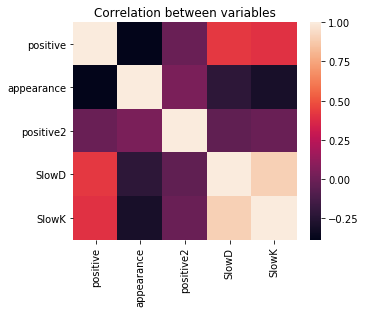

In [2911]:
corr = all_data.corr()
f, ax = plt.subplots(figsize=(5, 4))
plt.title("Correlation between variables")
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [2912]:
from sklearn.model_selection import train_test_split

all_data['timestamp'] = pd.to_datetime(all_data['timestamp'], format='%Y-%m-%d')
all_data.index = all_data['timestamp']

feature_cols = ['positive', 'appearance', 'positive2', 'SlowD', 'SlowK']
# feature_cols = ['positive2']
target = 'action'
X = all_data[feature_cols]
y = all_data[target]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [2913]:
result = pd.DataFrame({ 'pred': y_pred, 'test': y_test }, columns=['pred','test'])
result

,pred,test
timestamp,,
2001-02-28,L,S
2007-05-31,L,L
2000-02-29,L,S
2003-09-30,S,L
2008-01-31,L,S
2008-07-31,S,S
2002-11-29,L,L
2005-04-29,L,L
2011-11-30,L,S


In [2914]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.5517241379310345